In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Parameters
nx = 400  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 0.9  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(15000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 250
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

CFL Number: 0.7182000000000002
Epoch 0, Loss: 0.07068008184432983, PDE Loss: 0.002220409456640482, IC Loss: 0.04768771305680275, Boundary Loss: 0.0163311418145895
Epoch 1000, Loss: 0.005347448401153088, PDE Loss: 0.0003162385255564004, IC Loss: 0.004166450351476669, Boundary Loss: 0.00023228273494169116
Epoch 2000, Loss: 0.00014759732584934682, PDE Loss: 3.7146310205571353e-05, IC Loss: 1.3528807357943151e-05, Boundary Loss: 2.26295851462055e-05
Epoch 3000, Loss: 3.9946451579453424e-05, PDE Loss: 7.961727533256635e-06, IC Loss: 7.218445261969464e-06, Boundary Loss: 8.842824172461405e-06
Epoch 4000, Loss: 1.758589132805355e-05, PDE Loss: 4.539859219221398e-06, IC Loss: 1.0313751772628166e-06, Boundary Loss: 2.9349378110055113e-06
Epoch 5000, Loss: 6.244583801162662e-06, PDE Loss: 1.6139401850523427e-06, IC Loss: 5.77507250909548e-07, Boundary Loss: 8.252559950960858e-07
Epoch 6000, Loss: 8.410867849306669e-06, PDE Loss: 1.5148824559219065e-06, IC Loss: 2.873867742891889e-06, Boundary Lo

ts
Upwind MSE: 0.0372349904549188
Upwind Norm: 3.8592740485702124
NN MSE: 1.960140767636751e-06
NN Norm: 0.028001005465066793


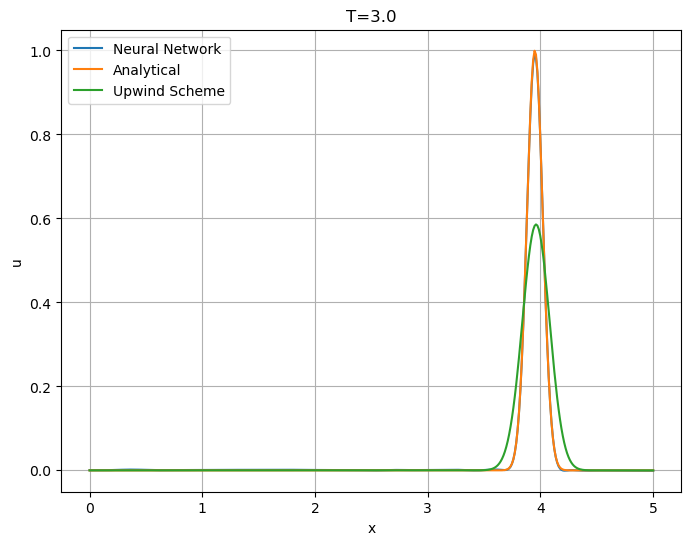

In [3]:
# Plot the results
plt.figure(figsize=(8, 6))

# Time Step
time = 3.0

##############################################
# NN Solution
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot NN
t_test = torch.full_like(x_test,time) # Creates a vector with the same shape as x_test with a constant value equal to n
with torch.no_grad(): 
    u_nn = model(x_test, t_test).detach().numpy().flatten()  # Detach tensor before converting to NumPy
plt.plot(x, u_nn, label="Neural Network")

################################################
# Analytical Solution

x_shifted = (x - a * time) % L  # Apply periodic boundary condition
u_analytical = np.exp(-((x_shifted - L/4) / 0.1) ** 2)
plt.plot(x, u_analytical, label="Analytical")

##############################################
# Upwind Scheme
# Initial condition: Gaussian pulse
u = np.exp(-((x - L/4) / 0.1) ** 2)

u_new = np.zeros_like(u)

for n in range(nt):
    # Apply Upwind update (first-order)
    u_new[1:] = u[1:] - CFL * (u[1:] - u[:-1])  # Forward in time, backward in space

    # Periodic boundary condition: Update the first point using the last point
    u_new[0] = u[0] - CFL * (u[0] - u[-1])

    # Update the field
    u[:] = u_new[:]

    # Plot at specific step and store
    if n == time*100:
        print('ts')
        u_upwind = u
        plt.plot(x, u, label="Upwind Scheme")
################################################


# Calculate errors (MSE)
upwind_diffs = u_analytical - u_upwind
upwind_mse = np.mean(np.square(upwind_diffs))
upwind_norm = np.linalg.norm(upwind_diffs)
print("Upwind MSE: " + str(upwind_mse))
print("Upwind Norm: " + str(upwind_norm))

nn_diffs = u_analytical - u_nn
nn_mse = np.mean(np.square(nn_diffs))
nn_norm = np.linalg.norm(nn_diffs)
print("NN MSE: " + str(nn_mse))
print("NN Norm: " + str(nn_norm))

# Set up plot
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.grid()
plt.title(f"T={time}")
plt.show()

In [4]:
u_nn.shape

(400,)

In [5]:
u_nn


array([ 3.99239361e-04,  3.97592783e-04,  3.97562981e-04,  3.98494303e-04,
        4.00058925e-04,  4.02539968e-04,  4.06377017e-04,  4.12471592e-04,
        4.22015786e-04,  4.36402857e-04,  4.57264483e-04,  4.86023724e-04,
        5.24155796e-04,  5.72539866e-04,  6.32070005e-04,  7.02820718e-04,
        7.84464180e-04,  8.76218081e-04,  9.76428390e-04,  1.08347088e-03,
        1.19458884e-03,  1.30707771e-03,  1.41802430e-03,  1.52424723e-03,
        1.62263960e-03,  1.71043724e-03,  1.78481638e-03,  1.84370577e-03,
        1.88552588e-03,  1.90908462e-03,  1.91361457e-03,  1.89960748e-03,
        1.86737627e-03,  1.81820244e-03,  1.75403059e-03,  1.67678297e-03,
        1.58882886e-03,  1.49286538e-03,  1.39170140e-03,  1.28787756e-03,
        1.18439645e-03,  1.08345598e-03,  9.87388194e-04,  8.98264349e-04,
        8.17477703e-04,  7.46257603e-04,  6.85624778e-04,  6.35869801e-04,
        5.97335398e-04,  5.69470227e-04,  5.52058220e-04,  5.44212759e-04,
        5.45047224e-04,  